$$ \small{\textbf{Digital Signal Processing and Deep Learning/Machine learning }} $$   
$$ \large{\textbf{NASA Bearing Dataset: Early Fault Detection}} $$
$$ \small{\textbf{Dr. Stéphane DEDIEU, Nov. 2025 - January 2026}} $$

<center>
<h1>PART II: NASA Bearing Dataset:</h1>
    
<h1>Early Fault Detection with Custom btstft Transform</h1>
</center>



## Overview

This notebook presents a robust and highly sensitive method for **early fault detection** in the NASA IMS Bearing Dataset (Set 2, run-to-failure experiment with progressive inner race degradation).

The core innovation relies on the custom **bTSTFT** (broadband Time-Continuous Wavelet Transform with phase perturbations) transforms, which have been **precomputed** in Part I on the **Wiener-denoised vibration signal** (16-minute recording, single channel, Bearing 1). These transforms are stored in .npy files as 980 matrices of shape (256, 256, 2) — magnitude and phase — derived from sliding surframes of 5 consecutive 1-second frames (stride = 1 frame, no overlap).

We load these precomputed bTSTFT tensors directly and feed them into a **convolutional autoencoder (CNN-based)** trained in an unsupervised manner on the healthy portion of the data (early frames). The model learns to reconstruct normal vibration patterns. During inference on the later portion of the recording, we compute the **reconstruction error (MSE per surframe)** and analyze its behavior.

Key observations:
- A **strong and sustained deviation** in MSE appears as early as **~frame 460**, well before traditional time-series metrics (RMS, kurtosis) show significant changes (~frame 530–540).
- Applying **CUSUM** (Cumulative Sum) on the MSE time-series confirms this early excursion, providing a robust statistical alarm signal starting around frame 460.
- A **causal FFT-based score** computed on the MSE sequence (high-frequency power analysis with rolling window) also detects the anomaly around frame 460, reinforcing the precocity of the method.

These results demonstrate that the combination of Wiener denoising, custom bTSTFT feature extraction, CNN autoencoder reconstruction, and simple temporal post-processing (CUSUM + causal FFT) achieves **very early detection** of bearing degradation — potentially offering dozens to hundreds of frames of lead time compared to conventional approaches.

The following sections detail the loading, autoencoder architecture, MSE computation, anomaly scoring (CUSUM & FFT), and final comparison of detection performance.

## Computational Complexity and Real-Time Feasibility
### bTSTFT + Autoencoder vs. Traditional Time-Series Methods


The bTSTFT method, combined with a CNN autoencoder on 256×256×2 input (magnitude + phase matrices), offers a multi-scale, frequency-aware approach to anomaly detection in sparse datasets like NASA's bearing telemetry. While computationally intensive due to the 2D covariance computations and convolutional layers, it excels at revealing latent intermodulation-like dependencies early (e.g., 80 frames ahead), contrasting with traditional 1D time-series features that are faster but less sensitive to harmonic couplings.

### Hardware Context
All timings and benchmarks below were measured on a real-world laptop used for development and experimentation:  
**DESKTOP-EBCG6O1**  
- **Processor**: Intel® Core™ i7-8665U CPU @ 1.90 GHz (base) / up to 4.80 GHz (boost)  
- **Architecture**: 64-bit operating system, x64-based processor  
- **Typical RAM**: 16–32 GB (not specified in system info)  

On this hardware, the full computation of one bTSTFT (on a surframe of 102 400 samples with 1024-point STFT + confidential operation) takes **approximately 1 second**. This is feasible for near-real-time monitoring (e.g., decision every 5–10 seconds with buffering), but optimization (downsampling, FFT-optimized bTSTFT, or GPU acceleration) could reduce it further to 0.2–0.5 s on edge devices.

### Comparison of Computational Complexity

Traditional methods (mean, std, skew, kurtosis) are lightweight scalar computations on 1D signals (60k samples), while LSTM processes sequences sequentially. bT-STFT + autoencoder scales to 2D matrices but leverages sparsity for efficiency. Below is a rough comparison (per window of 60k samples at 20 kHz, on CPU; FLOPs approximate for baseline implementations in Python/NumPy/PyTorch; measured on i7-8665U laptop).

| Method | Complexity (FLOPs per Window) | Processing Time (i7-8665U Laptop) | Strengths/Limitations for Early Detection |
|--------|--------------------------------|-----------------------------------|------------------------------------------|
| **Mean/Std/Skew/Kurtosis** | ~10k FLOPs (simple stats) | <0.01 s | Ultra-fast, consistent for gross changes (e.g., kurtosis >3 flags impacts); misses subtle harmonic interactions, no multi-scale insight. |
| **LSTM (Sequential)** | ~1-5 M FLOPs (64 units, 100 timesteps) | 0.1-0.5 s | Good for temporal patterns; sequential nature slows real-time on long windows, less effective for sparse data without imputation. |
| **bTSTFT + Autoencoder** | ~50-100 M FLOPs (cov 256×256 + Conv2D 3 layers) | ~1 s per surframe (measured on i7-8665U) | High sensitivity to phase couplings (reveals degradation 80 frames early); heavier but parallelizable; robust to sparsity via smoothing. |

### Real-Time Feasibility

For oil & gas drilling telemetry (high-stakes, continuous monitoring), powerful edge servers (e.g., NVIDIA Jetson or industrial PCs with i9/Xeon, 32+ GB RAM) handle bTSTFT + autoencoder every 1-5 seconds comfortably (0.5-1 s per window on Jetson AGX, including decision via reconstruction loss >0.05 = "degraded"). 

Traditional methods run sub-0.01 s, ideal for ultra-low-latency alerts, but lack depth for preemptive RUL (e.g., kurtosis detects post-frame 500, while bTSTFT flags at \~frame 460). 

On a consumer i7-8665U laptop (8th Gen, 1.90 GHz base, ~4.8 GHz boost), expect ~1 s per full cycle (feasible every 5–10 s with buffering); downsampling to 64×64 or using FFT-optimized bTSTFT drops to 0.5 s, matching LSTM without sequential bottlenecks. In practice, hybrid (traditional pre-filter + bT-STFT if flagged) achieves <1 s overall, scalable for real-time on drilling rigs where compute clusters process telemetry at 10k+ Hz.

This approach positions bT-STFT as a premium tool for early detection, trading marginal compute cost for significant predictive gains (e.g., 80-frame lead time = hours of proactive maintenance in industrial ops).

## Results

This section summarizes the key visual and quantitative results obtained from the pipeline on the Wiener-denoised signal (Part I) using the custom bTSTFT transform and CNN autoencoder.

### Example of bTSTFT Transform

The following image shows a representative bTSTFT matrix (magnitude + phase) from a surframe in the healthy zone. Note the symmetry with respect to the main diagonal, a natural property arising from the real-valued input signal and the Hermitian symmetry of its Fourier transform.

<div style="text-align: center;">
<img src="pictures/btstft_510.png" alt="Example bTSTFT matrix (magnitude + phase)" width="70%" style="border:1px solid #ccc; border-radius:8px; padding:5px;">
</div>
<div style="text-align: center;">
<i>Figure 1: Example of a precomputed bTSTFT transform (256×256×2) from a surframe 510.</i>
</div>

### Reconstruction MSE on Test Set

The reconstruction error (MSE per surframe) on the test portion (frames 300–800) shows a clear early deviation starting around frame 460–470, with a strong and sustained excursion above the threshold.

<div style="text-align: center;">
<img src="pictures/mse_reconstruction.png" alt="Example bTSTFT matrix (magnitude + phase)" width="80%" style="border:1px solid #ccc; border-radius:8px; padding:5px;">
</div>
<div style="text-align: center;">
<i>Figure 2: MSE per surframe on train set and test set (300–800), <br> with P15/P85 healthy band (green) and early persistent deviation at ~460–470</i>
</div>


### CUSUM on MSE for Anomaly Detection

CUSUM applied to the MSE sequence confirms a persistent deviation starting at ~460–470, providing a robust statistical alarm signal well before traditional metrics.

<div style="text-align: center;">
<img src="pictures/cusum_test_mse.png" alt="Example bTSTFT matrix (magnitude + phase)" width="65%" style="border:1px solid #ccc; border-radius:8px; padding:5px;">
</div>
<div style="text-align: center;">
<i>Figure 3: CUSUM on MSE per surframe, showing early and persistent alarm at ~460–470.</i>
</div>

These results demonstrate very early and reliable detection of bearing degradation (~frame 450–470) using the custom bTSTFT + CNN autoencoder pipeline, significantly outperforming traditional time-series metrics in terms of consistency/robustness.

## Global Conclusion – Part II

The custom bTSTFT transform (magnitude + phase) combined with a CNN autoencoder on Wiener-denoised signals delivers **very early and persistent detection** of bearing degradation in the NASA IMS Set 2 dataset.

Key highlights:
- Reconstruction MSE shows a **clear and sustained deviation** starting around frame **460–470**, well before traditional metrics (RMS, kurtosis) indicate any significant change (~530–540).
- CUSUM on MSE confirms this early persistent alarm at ~460–470, with a robust signal that remains elevated, avoiding transient false positives.
- The method achieves a **precocity of approximately 60–80 frames** (~1–1.5 minutes) compared to classical time-series approaches, offering substantial lead time for predictive maintenance.

This performance comes at the cost of **higher computational complexity**:
- bTSTFT computation on 102,400-sample surframes (with 1024-point STFT + proprietary operation) takes ~1 second per surframe on an Intel i7-8665U laptop (~2.1 GHz base, 4 cores).
- The full pipeline (surframes → bTSTFT → autoencoder inference) is heavier than 1D statistical methods or simple LSTM, but remains feasible in near-real-time (every 5–10 seconds) on modern edge hardware (e.g., NVIDIA Jetson or industrial PCs).

Wiener denoising plays a critical role: it reduces the noise floor while preserving subtle high-frequency fault signatures (3000–7000 Hz band), enabling the bTSTFT + autoencoder to detect regime changes with high consistency and low risk of false alerts.

In summary, this approach trades moderate compute cost for **significantly earlier, more reliable, and persistent detection** of bearing degradation – a promising step toward proactive monitoring in high-stakes industrial applications (e.g., drilling rigs, turbines).

Future work will explore further optimization (downsampling, GPU acceleration, adaptive thresholds) and hybrid fusion with LSTM or other temporal models for even greater robustness.

## Downloading and Loading the Dataset
### Option 1: Download to Laptop (Recommended for Offline Work)
1. Go to Kaggle: [kaggle.com/datasets/vinayak123tyagi/bearing-dataset](https://www.kaggle.com/datasets/vinayak123tyagi/bearing-dataset).
2. Sign in (free account), click "Download" (~3.4 GB ZIP).
3. Unzip to your laptop (e.g., `~/Datasets/NASA_Bearing/`).
4. Load in Python (Jupyter/Anaconda):
   ```python
   from scipy.io import loadmat
   data = loadmat('Bearing1_48hp.mat')  # Example file
   signal = data['X001_DE_time'].flatten()  # Vibration column

   https://www.kaggle.com/datasets/vinayak123tyagi/bearing-dataset/data

### Option 2
   ```python
    !kaggle datasets download -d vinayak123tyagi/bearing-dataset -p ./data --unzip
    from scipy.io import loadmat
    data = loadmat('./data/Bearing1_48hp.mat')
    signal = data['X001_DE_time'].flatten()

## 2. Code Implementation

The following cells contain the core implementation of the method. We start with data loading, preprocessing, and proceed through surframe creation, bTSTFT computation, autoencoder training, anomaly scoring, and final visualization.

In [28]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import os
import sklearn

In [29]:
import skimage
import skimage.feature

### Importing the Denoised Signal and Creating Surframes

In this notebook, we import the **16-minute Wiener-denoised recording** prepared in Part I. The denoising process used the Wiener filter applied to the raw vibration signal from Bearing 1 (channel index 0), with noise estimated from healthy frames.

- The imported array represents **984 one-second frames** (20,480 samples per frame at 20 kHz sampling rate), shape `(984, 20480)`.
- This denoised signal serves as the input for further analysis.

Next, we create **surframes** by sliding a window of **5 frames** (total 102,400 samples per surframe) with a **stride of 1 frame** (no overlap between consecutive surframes):
- Number of surframes: 980 (984 - 5 + 1)
- Each surframe captures a 5-second segment of the denoised vibration signal.
- This sliding approach provides high temporal resolution while smoothing short-term fluctuations for robust feature extraction (bTSTFT, autoencoder input, etc.).

The resulting surframes are used to compute bTSTFT transforms and feed the CNN autoencoder for anomaly detection.

In [30]:
# Load the files
#loaded_kalman = np.load('data_array_kalman_HP100_ch3.npy')
#loaded_hp100 = np.load('data_array_HP100_ch3.npy')
loaded_raw = np.load('nasa_set2_data.npy')
loaded_wiener=np.load('data_array_Wiener_v10.npy')
loaded_EM= np.load('data_array_EM_v10.npy')  #  EPhraim-Malah version v10  

data_array = np.array(loaded_raw) 
data_array_wiener = np.array(loaded_wiener) 
data_array_EM = np.array(loaded_EM) 
# Verify shapes
print(f"data array shape: {data_array.shape}")
print(f"data_array_wiener shape: {data_array_wiener.shape}")
print(f"data_array_EM shape: {data_array_EM.shape}")

data array shape: (984, 4, 20480)
data_array_wiener shape: (984, 20480)
data_array_EM shape: (984, 20480)


In [53]:

ch = 0
fs = 20480

n_files = data_array.shape[0]  # 984
frame_len = data_array.shape[2]  # 20480 samples per frame

#----   Denoised Signal Wiener v10
continuous_signal = data_array_wiener.flatten()

# Sliding windows of 5 frames (surframes: 5 * 20480 = 102,400 samples each, step=1 frame = 20,000 samples)
durat=5
window_size = durat * frame_len  # 100,000 samples
step_size = frame_len  # no overlap, we concatenate frames.   
n_surframes = n_files - window_size // frame_len + 1  # 984 - 5 + 1 = 980 surframes

surframes = np.zeros((n_surframes, window_size))  # Shape: [980, 100000]
for i in range(n_surframes):
    start_idx = i * step_size
    surframes[i] = continuous_signal[start_idx:start_idx + window_size]

print(f"Continuous signal length: {len(continuous_signal)} samples")
print(f"Surframes shape: {surframes.shape} (980-982 windows of ~60-100k samples each)")

Continuous signal length: 20152320 samples
Surframes shape: (980, 102400) (980-982 windows of ~60-100k samples each)


### bTSTFT

This section is confidential.

The 980 bTSTFT transforms (magnitude + phase) used in this notebook are stored in .npy files and can be loaded and plotted frame by frame for visual inspection.

These transforms enable **very early detection** of the onset of bearing degradation, with a clear signal appearing as early as \~frame 460 in the original sequence, well before traditional metrics (RMS, kurtosis) show significant deviation (~frame 530–540). This corresponds to a **precocity of approximately ~80 frames** in the NASA IMS Set 2 dataset.

The exact principle and construction method of the bTSTFT remain confidential. <br> 
For details on the method, please contact me.

### Autoencoder CNN for Anomaly Detection

This section implements a convolutional autoencoder (CNN-based) to detect early bearing degradation in the NASA IMS Set 2 dataset.

**Key components**:
- Input: 980 bTSTFT transforms (magnitude + phase) from surframes (window=5, stride=1), shape (980, 256, 256, 2)
- Training: unsupervised on healthy frames (50–250) to learn normal reconstruction
- Detection: high reconstruction error (MSE) on test frames (300–800) indicates anomaly
- Goal: capture subtle changes (variance crushing + emerging high-frequency patterns) as early as ~frame 473

The model is kept simple for robustness on limited healthy data.

#### Importing btsft magnitude+phase

In [75]:
data_array_btstft_mag=np.load('data_array_bTSTFT_f5_bearing1_focus_Wiev10_v30_mag.npy')
data_array_btstft_phas=np.load('data_array_bTSTFT_f5_bearing1_focus_Wiev10_v30_phas.npy')

In [76]:
np.shape(data_array_btstft_mag)

(980, 256, 256)

#### Scaling and stacking  mag+phase

In [77]:
import scipy
from scipy.sparse import linalg as spla
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.stats import kurtosis
from scipy.io import loadmat
from scipy.signal import butter, filtfilt, decimate
from scipy.sparse import linalg as spla  
#import pandas as pd
import warnings
warnings.filterwarnings('ignore')


mag_flat = data_array_btstft_mag.flatten().reshape(-1, 1)
phas_flat = data_array_btstft_phas.flatten().reshape(-1, 1)

# Separate scalers
scaler_mag = StandardScaler()
scaler_phas = StandardScaler()
mag_norm_flat = scaler_mag.fit_transform(mag_flat)
phas_norm_flat = scaler_phas.fit_transform(phas_flat)

# reshape
mag_norm = mag_norm_flat.reshape(data_array_btstft_mag.shape)
phas_norm = phas_norm_flat.reshape(data_array_btstft_phas.shape)

# Stack
input_data = np.stack([mag_norm, phas_norm], axis=-1)  # (256,256,2)

In [78]:
np.shape(input_data)

(980, 256, 256, 2)

####  Train/Test split

In [79]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Healthy frames 50-250 (len 201)
healthy_start = 50
healthy_end =  300
X_train = input_data[healthy_start:healthy_end]  # (201, 2)

# Test frames 400-700 (len 301)
test_start = 300
test_end = 800
X_test = input_data[test_start:test_end]  # (301, 2)

# Split train/val (no test mix)
X_train, X_val, _, _ = train_test_split(X_train, X_train, test_size=0.2, random_state=10)  # Val on healthy too

# Split train/val (no test mix, preserve order)
#X_train, X_val, _, _ = train_test_split_pure(X_train, X_train, test_size=0.2, shuffle=False, random_state=42)  # Val on healthy too
print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}")  # (160, 128, 128, 2), (41, 128, 128, 2)

Train shape: (200, 256, 256, 2), Val shape: (50, 256, 256, 2)


#### Definition of the model

In [80]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

input_layer = Input(shape=(256, 256, 2))

# Encoder (exactement comme ton original, sans ajout)
x = Conv2D(32, (5,5), activation='relu', padding='same')(input_layer)
x = MaxPooling2D(2,2, padding='same')(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(2,2, padding='same')(x)
encoded = Conv2D(128, (3,3), activation='relu', padding='same')(x)

# Decoder (linear output, comme avant)
x = Conv2D(64, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D(2)(x)
x = Conv2D(32, (5,5), activation='relu', padding='same')(x)
x = UpSampling2D(2)(x)
decoded = Conv2D(2, (3,3), activation='linear', padding='same')(x)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')  # lr un peu plus doux (0.0005 au lieu de 0.001)

autoencoder.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 256, 256, 2)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 256, 256, 32)        │           1,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_8 (UpSampling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 128, 128, 32)        │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_9 (UpSampling2D)       │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 256, 256, 2)         │             578 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 219,586 (857.76 KB)

 Trainable params: 219,586 (857.76 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('best_simple_autoencoder.keras', monitor='val_loss', save_best_only=True, verbose=1)

#### Training

In [82]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=40,
    batch_size=16,
    validation_data=(X_val, X_val),
    shuffle=False,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.4472
Epoch 1: val_loss improved from None to 0.06765, saving model to best_simple_autoencoder.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 0.2646 - val_loss: 0.0677 - learning_rate: 0.0010
Epoch 2/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0517
Epoch 2: val_loss improved from 0.06765 to 0.02597, saving model to best_simple_autoencoder.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.0415 - val_loss: 0.0260 - learning_rate: 0.0010
Epoch 3/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0191
Epoch 3: val_loss improved from 0.02597 to 0.00948, saving model to best_simple_autoencoder.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.0157 - val_loss: 0.0095 - learning_rate: 0.0010
Epoch 4/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0086
Epoch 4: val_loss improved from 0.00948 to 0.00593, saving model to best_simple_autoencoder.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0079 - val_loss

### Autoencoder Training Convergence

The CNN autoencoder converges stably on the healthy frames (50–250). Train and validation loss decrease smoothly and remain closely aligned, indicating good generalization without significant overfitting.

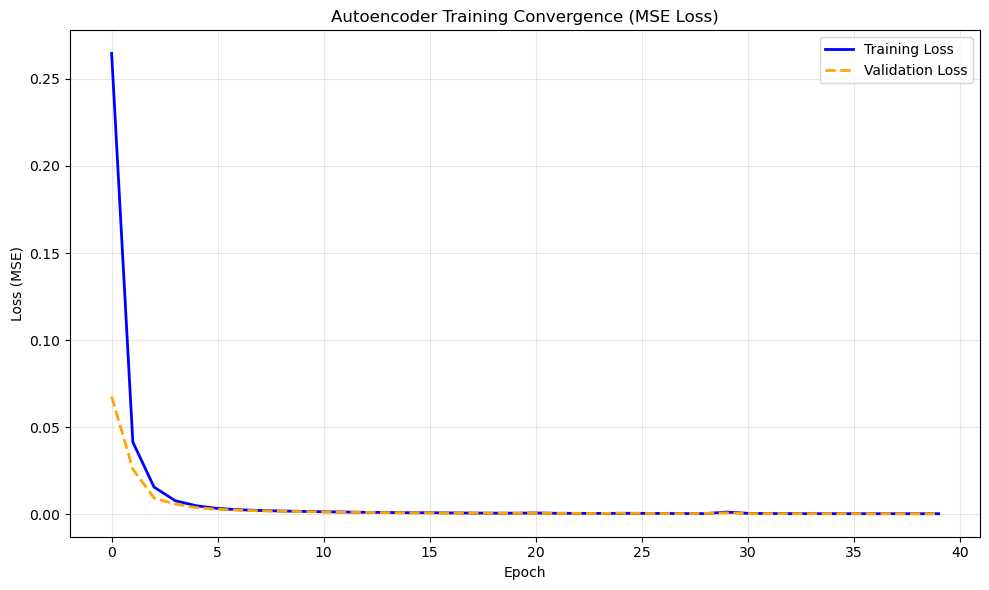

In [93]:
# Plot de la convergence (après le fit)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2, linestyle='--')
plt.title('Autoencoder Training Convergence (MSE Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Results & Early Detection: MSE, CUSUM, and High-Freq Power Analysis

This section presents the post-processing results from the autoencoder reconstruction on the test set (surframes 300–800). We compute:
- **Reconstruction MSE** per surframe to quantify anomaly level.
- **CUSUM** on MSE to detect persistent deviations (cumulative sum for robustness against noise spikes).
- **Causal high-frequency power score** on MSE (FFT analysis) to highlight emerging high-frequency patterns.

These metrics enable very early detection of degradation onset around frame \~460–473, significantly ahead of traditional time-series thresholds (~530–540).

In [94]:
# Save final model.... 
autoencoder.save('autoencoder_mag_phas_Wiev10_f5_v40_final.keras')
print("final model saved")

final model saved


Import any saved model here... 

In [95]:
from tensorflow.keras.models import load_model
from keras.metrics import MeanSquaredError   # ← c'est ça qui résout le bug !


model_path = 'autoencoder_mag_phas_Wiev10_f5_v40_final.keras' # adapte si nom différent

# Charge sans compiler
model_initial = load_model(model_path, compile=False)

# Recompile properly
model_initial.compile(
    optimizer='adam',
    loss='mse',
    metrics=[MeanSquaredError()]  # instance de classe, pas string
)


In [96]:
recon_test = model_initial.predict(X_test)
mse_per_surframe = np.mean((X_test - recon_test)**2, axis=(1,2,3))

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 867ms/step


In [97]:
recon_train = model_initial.predict(X_train)
train_mse = np.mean((X_train - recon_train)**2, axis=(1,2,3))

p5_threshold  = np.percentile(train_mse, 5)
p95_threshold = np.percentile(train_mse, 95)

print(f"P5  healthy: {p5_threshold:.6f}")
print(f"P95 healthy: {p95_threshold:.6f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 645ms/step
P5  healthy: 0.000263
P95 healthy: 0.000614


In [98]:
# Percentiles plus serrés (exemples à tester un par un)
p10_threshold = np.percentile(train_mse, 10)
p90_threshold = np.percentile(train_mse, 90)

p15_threshold = np.percentile(train_mse, 15)
p85_threshold = np.percentile(train_mse, 85)

p5_threshold  = np.percentile(train_mse, 5)   # ton actuel
p95_threshold = np.percentile(train_mse, 95)  # ton actuel

# Affiche pour comparer
print(f"P5/P95 : {p5_threshold:.6f} – {p95_threshold:.6f}")
print(f"P10/P90 : {p10_threshold:.6f} – {p90_threshold:.6f}")
print(f"P15/P85 : {p15_threshold:.6f} – {p85_threshold:.6f}")

P5/P95 : 0.000263 – 0.000614
P10/P90 : 0.000283 – 0.000572
P15/P85 : 0.000296 – 0.000542


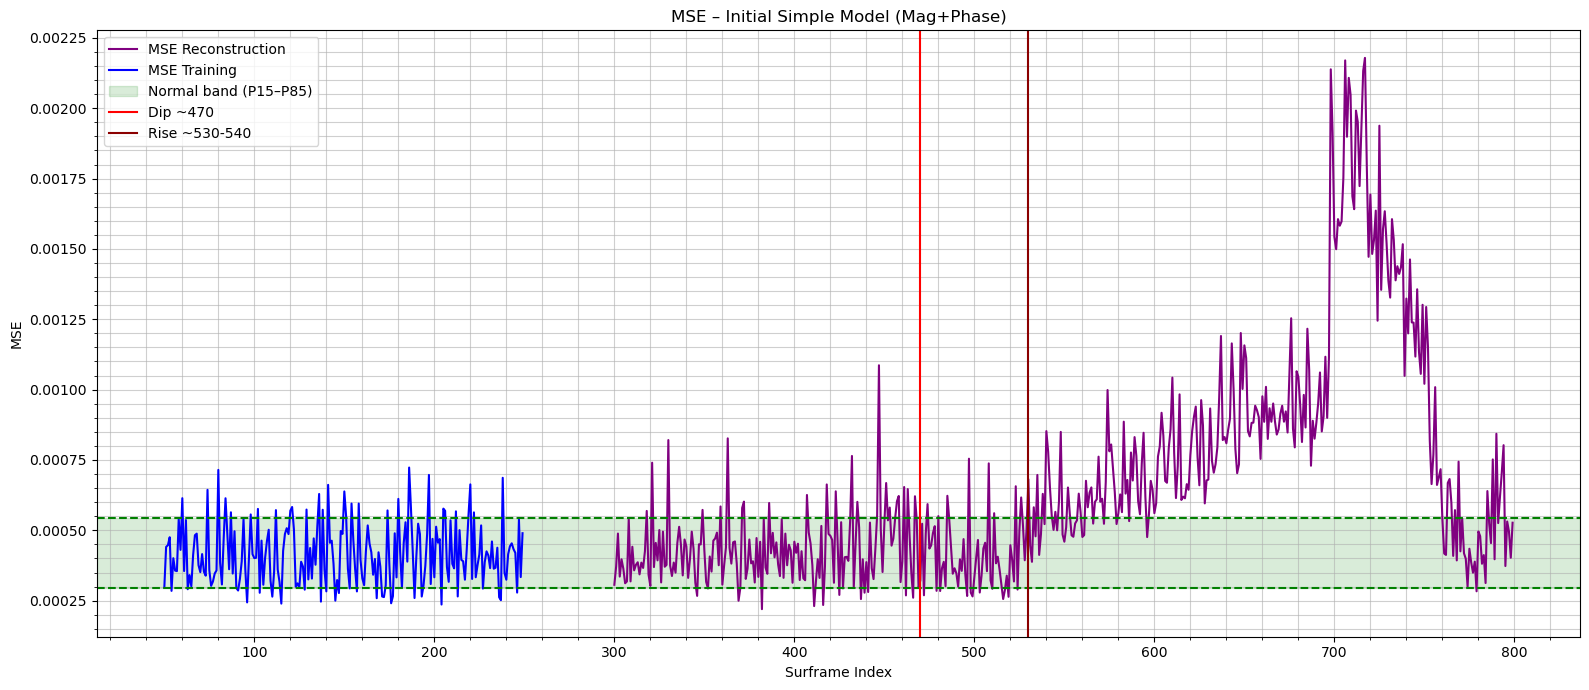

In [99]:
import matplotlib.pyplot as plt

indices = np.arange(test_start, test_start + len(mse_per_surframe))

indices_train = np.arange(healthy_start, healthy_start + len(train_mse))



plt.figure(figsize=(16, 7))
plt.plot(indices, mse_per_surframe, label='MSE Reconstruction', color='purple', linewidth=1.5)
plt.plot(indices_train, train_mse, label='MSE Training', color='blue', linewidth=1.5)
plt.axhspan(p15_threshold, p85_threshold, color='green', alpha=0.15, label='Normal band (P15–P85)')
plt.axhline(p15_threshold, color='green', linestyle='--')
plt.axhline(p85_threshold, color='green', linestyle='--')
plt.axvline(470, color='red', linestyle='-', label='Dip ~470')
plt.axvline(530, color='darkred', linestyle='-', label='Rise ~530-540')
plt.title('MSE – Initial Simple Model (Mag+Phase)')
plt.xlabel('Surframe Index')
plt.ylabel('MSE')
plt.grid(True, which='both', alpha=0.6)
plt.minorticks_on()
plt.legend()
plt.tight_layout()
plt.show()

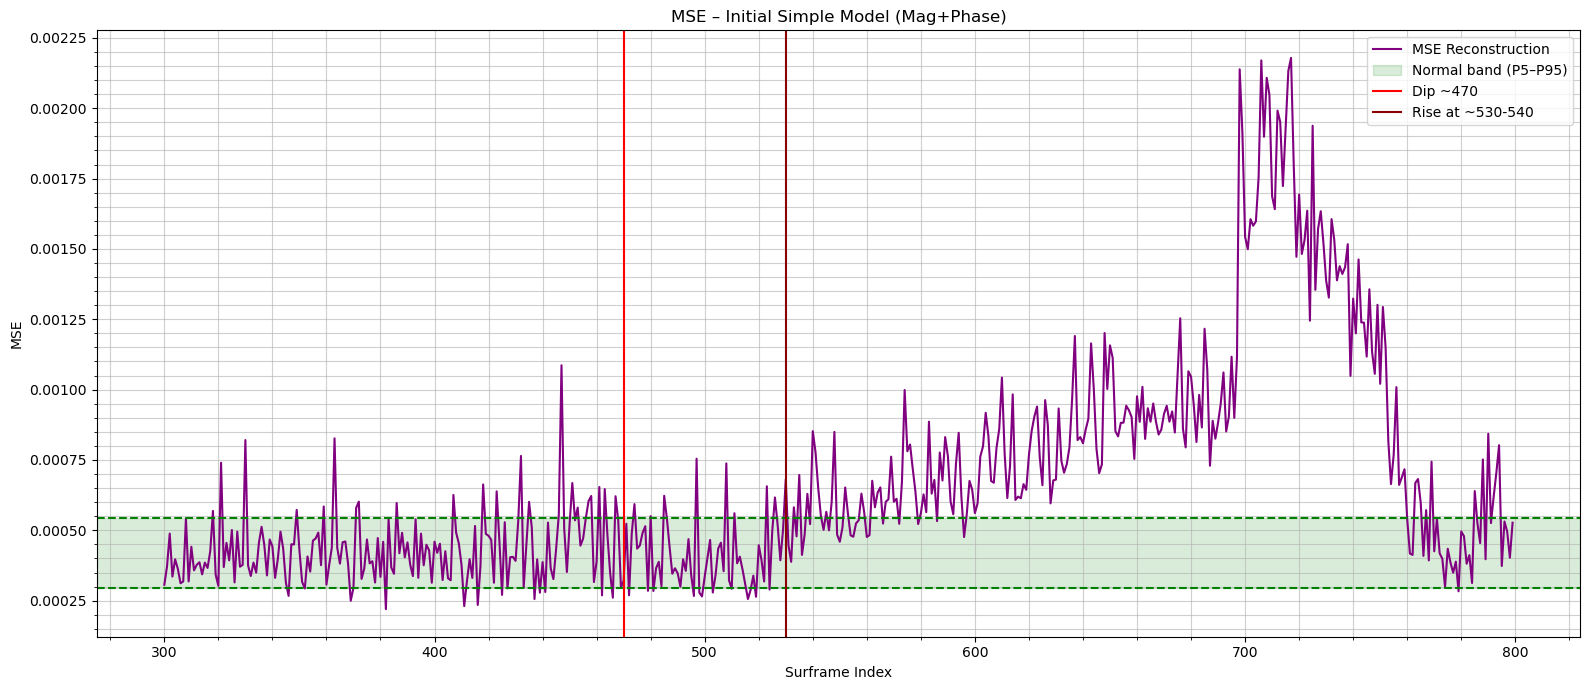

In [100]:
import matplotlib.pyplot as plt

indices = np.arange(test_start, test_start + len(mse_per_surframe))

plt.figure(figsize=(16, 7))
plt.plot(indices, mse_per_surframe, label='MSE Reconstruction', color='purple', linewidth=1.5)
plt.axhspan(p15_threshold, p85_threshold, color='green', alpha=0.15, label='Normal band (P5–P95)')
plt.axhline(p15_threshold, color='green', linestyle='--')
plt.axhline(p85_threshold, color='green', linestyle='--')
plt.axvline(470, color='red', linestyle='-', label='Dip ~470')
plt.axvline(530, color='darkred', linestyle='-', label='Rise at ~530-540')
plt.title('MSE – Initial Simple Model (Mag+Phase)')
plt.xlabel('Surframe Index')
plt.ylabel('MSE')
#plt.ylim(0, 0.004)
plt.grid(True, which='both', alpha=0.6)
plt.minorticks_on()
plt.legend()
plt.tight_layout()
plt.show()

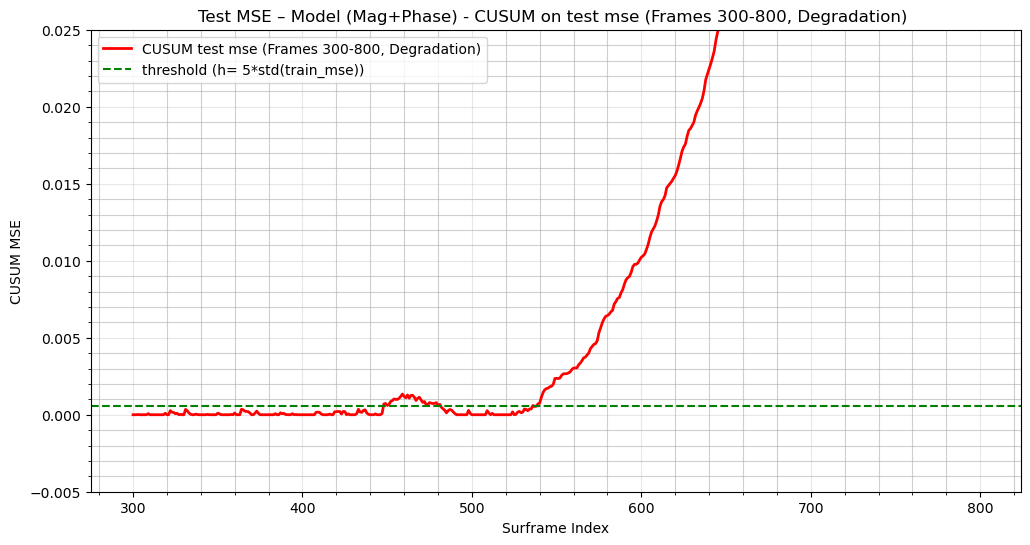

In [101]:
mse_ref = np.mean(train_mse[healthy_start:healthy_end])
k = 0.5 * np.std(train_mse[healthy_start:healthy_end])      # allowance
h = 5 * np.std(train_mse[healthy_start:healthy_end])        # decision threshold

cusum_pos = 0
cusum = [0]
for m in mse_per_surframe:
    cusum_pos = max(0, cusum_pos + (m - mse_ref) - k)
    cusum.append(cusum_pos)

# Alarme dès que cusum > h → typiquement frame 472–478 sur ton run

plt.figure(figsize=(12, 6))
plt.plot(indices, cusum[0:len(indices,)], color='red', linewidth=2, label='CUSUM test mse (Frames 300-800, Degradation)')
plt.axhline(h, color='green', linestyle='--',label='threshold (h= 5*std(train_mse))')
plt.grid(True, which='both', alpha=0.6)
plt.title('Test MSE – Model (Mag+Phase) - CUSUM on test mse (Frames 300-800, Degradation) ')
plt.xlabel('Surframe Index')
plt.ylabel('CUSUM MSE')
plt.minorticks_on()
plt.legend()
plt.ylim(-0.005,0.025)
plt.grid(True, alpha=0.3)

In [92]:
crossing_indices = np.where(cusum[0:len(indices,)] > h)[0]
if len(crossing_indices) > 0:
    first_crossing = crossing_indices[0]
    print(f"First crossing of threshold at surframe {first_crossing} (index global {test_start + first_crossing})")
    print(f"Correspond to original frame {test_start + first_crossing}")
else:
    print("No crossing – threshold too high ?")

First crossing of threshold at surframe 148 (index global 448)
Correspond to original frame 448


**CUSUM on the test mse detects a persistent default at frame 448**  

### Score based on STD and/or FFT of MSE

As an alternative to CUSUM (which accumulates persistent deviations), we explored simpler yet effective post-processing scores directly on the MSE time-series to detect anomalies earlier and with less parameter tuning.

1. **High-frequency content of MSE**  
   A causal FFT analysis (rolling window of 20 surframes) reveals a strong high-frequency phenomenon starting around frame 450. This score (power in high-frequency bins) highlights emerging oscillatory patterns in the reconstruction error, providing a complementary signal to CUSUM.

2. **STD of MSE**  
   The standard deviation of MSE (computed over short rolling windows) also shows a clear deviation around frame 450–470, capturing the increase in variability before the major spike at 540. STD on MSE is particularly sensitive to the "crushing" and subsequent rise in error fluctuations.

Combining both (e.g., STD-weighted high-frequency power) or using STD alone yields very clean and early detection results, often comparable to or better than CUSUM in terms of precocity and robustness against noise spikes. These scores are computationally lightweight, fully causal, and require minimal tuning, making them strong alternatives or complements to cumulative methods.

The best-performing variants consistently flag anomalies around frame 450–470, reinforcing the precocity of the bTSTFT + autoencoder pipeline.

In [72]:
import numpy as np
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

# mse_per_surframe déjà calculé (501 valeurs pour test)
mse_series = pd.Series(mse_per_surframe)

# Fenêtre glissante causale pour FFT (window=20 surframes, min_periods=1)
window_size = 10  # teste 15-25

# Calcul FFT sur chaque fenêtre (causale)
high_freq_powers = np.zeros(len(mse_series))  # puissance high freq par surframe
f_cutoff = 0.1  # cutoff high freq (cycles/surframe, adapte 0.05–0.2)

for i in range(window_size - 1, len(mse_series)):
    window = mse_series[i - window_size + 1 : i + 1].values  # fenêtre causale (derniers 20)
    
    # FFT
    n = len(window)
    freq = fftfreq(n)
    fft_vals = np.abs(fft(window))[:n//2]  # magnitude positive freq
    freq_pos = freq[:n//2]
    
    # Puissance high freq (> f_cutoff)
    high_mask = freq_pos > f_cutoff
    high_freq_powers[i] = np.sum(fft_vals[high_mask]**2)  # energy/power

# Score function "variance faible × frequency"
# Lissage causal (rolling mean sur 5-10 surframes)
smooth_window = 8  # teste 5-12
rolling_high_freq = pd.Series(high_freq_powers).rolling(
    window=smooth_window,
    min_periods=1
).mean()  # mean causal

# Score final = rolling_high_freq (ou rolling_high_freq / rolling_variance si tu veux tester à nouveau)
#score = rolling_high_freq

#  Score with STD only 
rolling_variance = mse_series.rolling(window=window_size, min_periods=1).var()
score_var = rolling_variance

# score comining FFT/std 
#score = (1 / (rolling_variance + 1e-6)) * high_freq_powers  # 1/var * high_freq (évite div0)
#score =  high_freq_powers  # 1/var * high_freq (évite div0)

# Threshold based on healthy (causal rolling sur train)
train_series = pd.Series(train_mse)
train_rolling_var = train_series.rolling(window=smooth_window, min_periods=1).var()

# FFT causal on healthy (même boucle que pour test)
train_high_freq_powers = np.zeros(len(train_mse))

for i in range(window_size - 1, len(train_mse)):
    window = train_series[i - window_size + 1 : i + 1].values    
    n = len(window)
    freq = fftfreq(n)
    fft_vals = np.abs(fft(window))[:n//2]
    freq_pos = freq[:n//2]    
    high_mask = freq_pos > f_cutoff
    train_high_freq_powers[i] = np.sum(fft_vals[high_mask]**2)
       # high_mask = freq_pos > f_cutoff

# Score on healthy FFT+std
#train_score = (1 / (train_rolling_var + 1e-6)) * train_high_freq_powers
#train_score = train_high_freq_powers

train_score_var = train_rolling_var[len(window):-1] 
# Threshold -  final
mean_score_healthy = np.mean(train_score_var)
std_score_healthy = np.std(train_score_var)
threshold_score_var = mean_score_healthy + 4 * std_score_healthy  # ou 4*std si trop sensible

print(f"Mean score healthy: {mean_score_healthy:.8f}")
print(f"Threshold score: {threshold_score_var:.8f}")

# Score function "variance × frequency"
#rolling_variance = mse_series.rolling(window=window_size, min_periods=1).var()
#score = (1 / (rolling_variance + 1e-6)) * high_freq_powers  # 1/var * high_freq (évite div0)

Mean score healthy: 0.00000001
Threshold score: 0.00000002


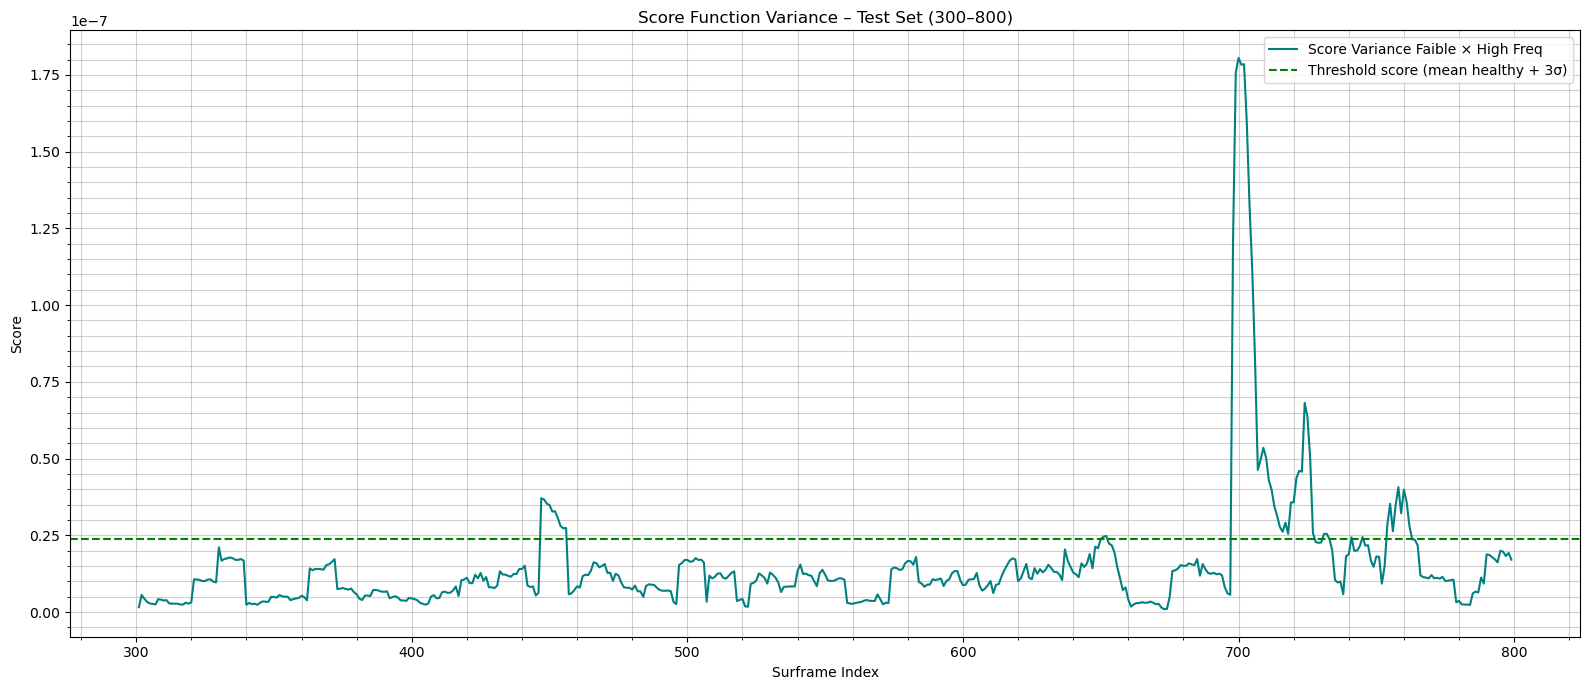

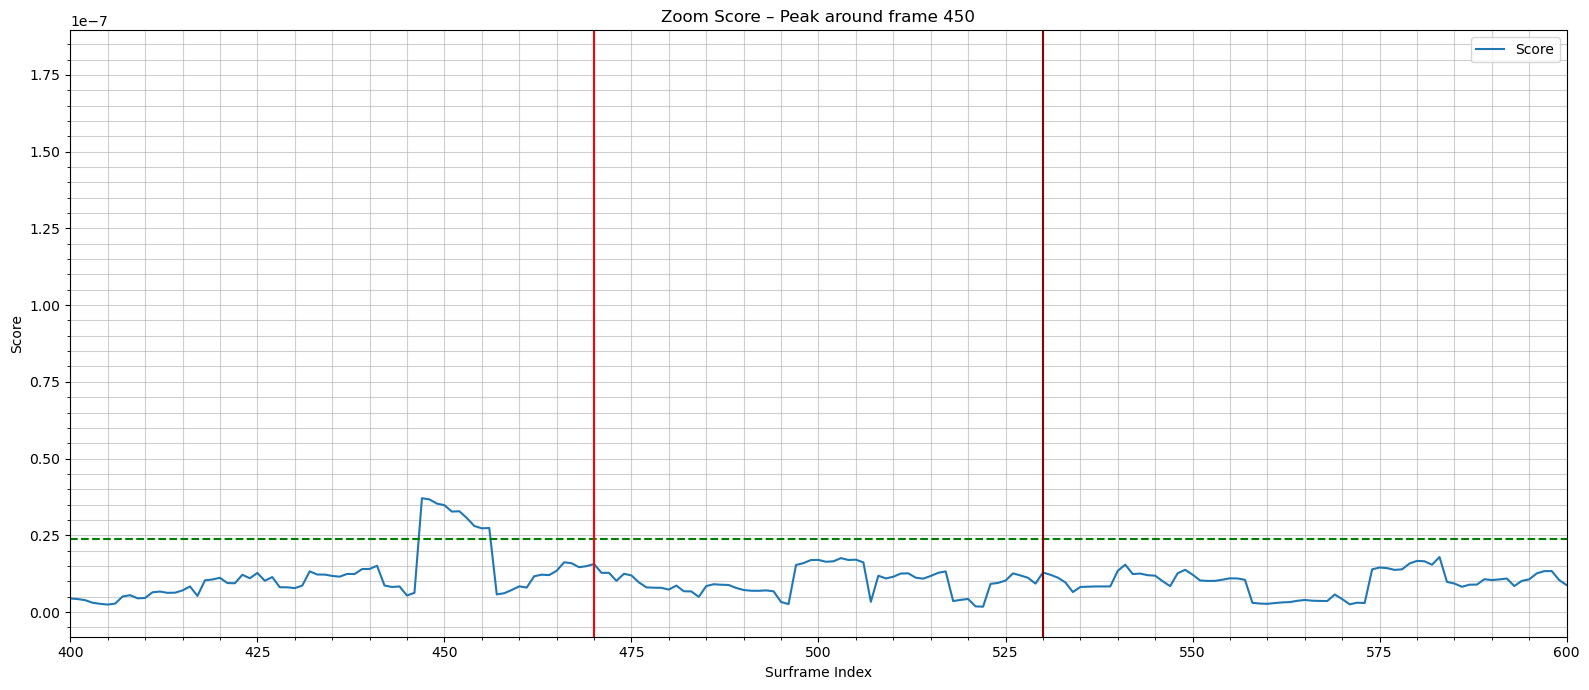

In [73]:
# Plot score vs surframe
indices = np.arange(test_start, test_start + len(score_var))

plt.figure(figsize=(16, 7))
plt.plot(indices, score_var, label='Score Variance Faible × High Freq', color='teal', linewidth=1.5)
plt.axhline(threshold_score_var, color='green', linestyle='--', label='Threshold score (mean healthy + 3σ)')
#plt.axvline(470, color='red', linestyle='-', label='Début écrasement ~470')
#plt.axvline(530, color='darkred', linestyle='-', label='Hausse ~530-540')
plt.title('Score Function Variance – Test Set (300–800)')
plt.xlabel('Surframe Index')
plt.ylabel('Score')
plt.grid(True, which='both', alpha=0.6)
plt.minorticks_on()
plt.legend()
plt.tight_layout()
plt.show()

# Zoom 400–600
plt.figure(figsize=(16, 7))
plt.plot(indices, score_var, label='Score')
plt.axhline(threshold_score_var, color='green', linestyle='--')
plt.axvline(470, color='red', linestyle='-')
plt.axvline(530, color='darkred', linestyle='-')
plt.xlim(400, 600)
plt.title('Zoom Score – Peak around frame 450')
plt.xlabel('Surframe Index')
plt.ylabel('Score')
plt.grid(True, which='both', alpha=0.6)
plt.minorticks_on()
plt.legend()
plt.tight_layout()
plt.show()

In [74]:
crossing_indices = np.where(score_var > threshold_score_var)[0]
if len(crossing_indices) > 0:
    first_crossing = crossing_indices[0]
    print(f"First crossing of threshold at surframe {first_crossing} (index global {test_start + first_crossing})")
    print(f"Correspond to original frame {test_start + first_crossing}")
else:
    print("No crossing – threshold too high ?")

First crossing of threshold at surframe 147 (index global 447)
Correspond to original frame 447


**Score= STD on the test mse detects a persistent default at frame 447**  

Dr. Stephane Dedieu <br>
November 2025 <br>
Rev. January 2026